In [2]:
import numpy as np
import pandas as pd

from IPython.core.display import display

In [3]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('# of users: ', n_users)
print('# of items: ', n_items)

('# of users: ', 943)
('# of items: ', 1682)


In [4]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
from sklearn import cross_validation
train_data, test_data = cross_validation.train_test_split(df, test_size=0.25)

display(train_data.head())
display(test_data.head())

,user_id,item_id,rating,timestamp
95928,796,33,3,893048471
4635,119,628,4,874775185
70379,276,1483,3,892436354
58616,85,50,5,882813248
64652,890,324,4,882404093


,user_id,item_id,rating,timestamp
96344,358,208,2,891270510
90338,659,1044,4,891386071
78818,130,1157,3,880396861
90654,399,919,2,882510379
25686,206,748,4,888179833


In [9]:
# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

In [8]:
R

array([[ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [10]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [11]:
I

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [12]:
# Calcurate the RMSE
def rmse(I, R, Q, P):
    SSE = np.sum((I * (R - np.dot(P.T, Q)))**2)
    return np.sqrt(SSE / len(R[R > 0]))

# Implementing the ALS Algorithm

In [22]:
# Regularization weight
lmbda = 0.1
# Dimensionlaity of latent feature space
k = 20 
# Number of users and items
m, n = R.shape
# Number of epochs
n_epochs = 15
# Latent user feature matrix
P = 3 * np.random.rand(k, m)
# Latent movie feature matrix
Q = 3 * np.random.rand(k, n)
# Avg. rating for each movie
Q[0, :] = R[R != 0].mean(axis=0)
# ((k * k)-dimensional identity matrix)
E = np.eye(k)

In [48]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        # Number of items user i has rated
        nui = np.count_nonzero(Ii)
        if nui == 0:
            nui = 1
        
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:, i] = np.linalg.solve(Ai, Vi)

        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        # Number of users that rated item j
        nmj = np.count_nonzero(Ij)
        if (nmj == 0): 
            nmj = 1

        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:, j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
        
        
    train_rmse = rmse(I, R, Q, P)
    test_rmse = rmse(I2, T, Q, P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

    print("[Epoch %d/%d] train error: %f, test error: %f" \
            %(epoch+1, n_epochs, train_rmse, test_rmse))

print("Algorithm converged")

[Epoch 1/15] train error: 1.275884, test error: 1.378762
[Epoch 2/15] train error: 0.941519, test error: 1.120839
[Epoch 3/15] train error: 0.822720, test error: 1.041828
[Epoch 4/15] train error: 0.766191, test error: 1.004216
[Epoch 5/15] train error: 0.734554, test error: 0.982494
[Epoch 6/15] train error: 0.714884, test error: 0.968682
[Epoch 7/15] train error: 0.701771, test error: 0.959427
[Epoch 8/15] train error: 0.692594, test error: 0.952997
[Epoch 9/15] train error: 0.685927, test error: 0.948394
[Epoch 10/15] train error: 0.680930, test error: 0.945011
[Epoch 11/15] train error: 0.677085, test error: 0.942464
[Epoch 12/15] train error: 0.674056, test error: 0.940508
[Epoch 13/15] train error: 0.671623, test error: 0.938977
[Epoch 14/15] train error: 0.669635, test error: 0.937761
[Epoch 15/15] train error: 0.667986, test error: 0.936783
Algorithm converged


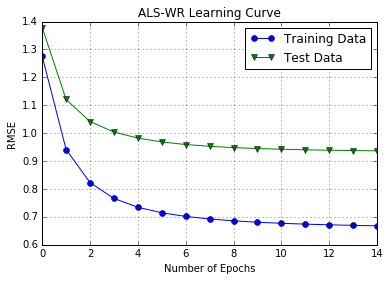

In [49]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [51]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R_hat = pd.DataFrame(np.dot(P.T,Q))
R = pd.DataFrame(R)

In [52]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']

display(ratings)

,Actual Rating,Predicted Rating
0,4.0,3.448145
6,4.0,3.624538
12,3.0,3.132362
99,4.0,3.606537
116,3.0,2.416230


In [53]:
predictions = R_hat.loc[16, R.loc[16, :] == 0] # Predictions for movies that the user 17 hasn't rated yet
top5 = predictions.sort_values(ascending=False).head(n=5)
recommendations = pd.DataFrame(data=top5)
recommendations.columns = ['Predicted Rating']

display(recommendations)

,Predicted Rating
172,4.221806
473,4.218673
168,4.218386
407,4.208240
113,4.164561
